In [ ]:
%pip install -Uq "unstructured[pdf]" pillow lxml
%pip install -Uq chromadb tiktoken
%pip install -Uq langchain langchain-community langchain-openai langchain-groq
%pip install -Uq python_dotenv
%pip install unstructured

In [ ]:
import os

# keys for the services we will use

os.environ["OPENAI_API_KEY"] = "sk-..."
os.environ["GROQ_API_KEY"] = "sk-..."
os.environ["LANGCHAIN_API_KEY"] = "sk-..."
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
output_path = "./content/"
# file_path = output_path + 'attention.pdf'
file_path = output_path + 'product.pdf'
print(file_path)

## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

In [2]:
# import os
from unstructured.partition.pdf import partition_pdf

# Set the Poppler path environment variable
# os.environ["POPPLER_PATH"] = r"C:\Program Files\poppler\poppler-24.08.0\Library\bin"

# Define your file path and output path
output_path = "content/"
file_path = output_path + 'product.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
try:
    chunks = partition_pdf(
        filename=r"C:\Users\ECQ956\Desktop\jupyter\Multimodal-Alejandra\content\product.pdf",
        infer_table_structure=True,            # extract tables
        strategy="hi_res",                     # mandatory to infer tables

        extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
        # image_output_dir_path=output_path,   # if None, images and tables will be saved in base64

        extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

        chunking_strategy="by_title",          # or 'basic'
        max_characters=300,                  # defaults to 500
        combine_text_under_n_chars=100,       # defaults to 0
        new_after_n_chars=400,

        poppler_path=r"C:\Program Files\poppler\poppler-24.08.0\Library\bin",  # Specify poppler_path here

        # extract_images_in_pdf=True,          # deprecated
    )
except FileNotFoundError as e:
    print(e)
    raise

# Optionally, print the chunks or process them as needed
for chunk in chunks:
    print(chunk)

Wonderful Oddities Shop - The Oddities

Collection
Step into the Wonderful Oddities Shop, a place where the mysterious and the enchanted intertwine. Tucked away in a forgotten alley, this shop offers rare artifacts imbued with magic, each carrying its own secrets and curses. Browse with caution—every item has a story, and some may change yours
forever.
ChronoLens Camera (Standard Edi�on)

• A beautifully aged polaroid camera wrapped in cracked leather, its buttons cold to the touch.

• When you take a picture, the film develops into a moment in time—not the present, but either past or future.
• A faint humming sound echoes before the image reveals itself.

• 2,000 SGD

| ChronoLens Camera (Standard Edition)

ChronoLens Camera (Standard Edition)

ChronoLens Camera (Limited Edi�on)

• Prints moving ghostly images—a scene unfolding before your eyes.
• If the photo develops in red hues, you have witnessed a moment fated to change your life forever.

• The camera occasionally trembles in yo

In [ ]:
# We get 2 types of elements from the partition_pdf function
# set([str(type(el)) for el in chunks])

len(chunks)
# chunks[3].metadata.orig_elements

In [ ]:
for ch in chunks[5].metadata.orig_elements:
    if "Table" in str(type(ch)):
        print (ch)

In [ ]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

tables=[]
# chunks[3].metadata.orig_elements

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

In [ ]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

### Separate extracted elements into tables, text, and images

In [4]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

texts = [element.text for element in texts]  # Adjust this depending on the structure of your CompositeElement.

In [9]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

#### Check what the images look like

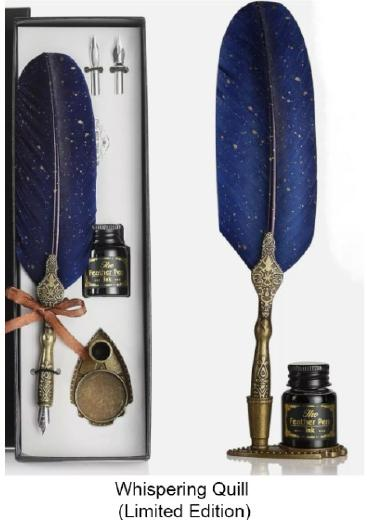

In [11]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[7])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [ ]:
%pip install -Uq langchain-groq

In [5]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [12]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing text.
Give a concise summary of the text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [14]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# # Summarize tables
# tables_html = [table.metadata.text_as_html for table in tables]
# table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jm6rjbykf3rsrx1vp679bhqk` service tier `on_demand` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.956s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'requests', 'code': 'rate_limit_exceeded'}}

### Image summaries

We will use gpt-4o-mini to produce the image summaries.

In [ ]:
%pip install -Uq langchain_openai

In [15]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is exactly the product that being sold in the wonderful oddities shop
                  """
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images)

In [53]:
text_summaries

['The Wonderful Oddities Shop, known as "The Oddities Collection", is a store featuring unusual and rare items, including taxidermy, medical specimens, and other bizarre artifacts.',
 'The Wonderful Oddities Shop is a mysterious store in a forgotten alley, selling rare magical artifacts with secrets and curses.',
 'An endless, timeless state of existence.',
 'The ChronoLens Camera is a polaroid camera that captures images of past or future moments when developed, rather than the present.',
 'The ChronoLens Camera, a Standard Edition, prints moving ghostly images of scenes unfolding in real-time, costing 2,000 SGD.',
 "The ChronoLens Camera (Limited Edition) is a special camera priced at 3,500 SGD, which may capture life-changing moments and sometimes shakes in the user's hands.",
 'The ChronoLens Camera, a cursed edition, captures photographs with a shadowy figure that appears closer in each subsequent image, also exhibiting eerie and unexplained phenomena such as lens fogging.',
 'The

## Load data and summaries to vectorstore

### Create the vectorstore

In [22]:
import uuid
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
    search_kwargs={"k": 4} 
)

### Load the summaries and link the to the original data

In [23]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# # Add tables
# table_ids = [str(uuid.uuid4()) for _ in tables]
# summary_tables = [
#     Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
# ]
# retriever.vectorstore.add_documents(summary_tables)
# retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

## Qdrant (outdated)

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, HnswConfig

qdrant_client = QdrantClient()

collection_name = "your_collection_name"

vectors_config = {
    "embedding": VectorParams(
        size=1536,  # Set the correct vector size for OpenAI embeddings
        distance="Cosine",  # or "Euclidean" depending on your use case
    )
}

print(f"Creating collection {collection_name} with the correct configuration.")
qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=vectors_config
)


In [ ]:
qdrant_client.delete_collection(collection_name=collection_name)


In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.models import HnswConfigDiff

qdrant_client = QdrantClient()

# Update the collection with new HNSW configuration
qdrant_client.update_collection(
    collection_name=collection_name,
    vectors_config={
        "embedding": {
            "hnsw_config": HnswConfigDiff(
                ef_construct=200,  # Correct field name for ef_construction
                m=16,
                full_scan_threshold=100  # Add the missing field
            )
        }
    }
)

In [ ]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from qdrant_client import QdrantClient
from qdrant_client.models import PointStruct
from sklearn.decomposition import PCA

# Initialize Qdrant client
qdrant_client = QdrantClient("http://localhost:6333")  # Replace with your Qdrant instance URL
collection_name = "your_collection_name"

# Initialize the OpenAI Embeddings model
embedding_function = OpenAIEmbeddings()

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=embedding_function)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Generate document IDs for text and image data
doc_ids = [str(uuid.uuid4()) for _ in texts]
img_ids = [str(uuid.uuid4()) for _ in images]

# Generate embeddings for texts using OpenAIEmbeddings
def generate_text_embeddings(texts):
    return embedding_function.embed_documents(texts)

# Function to reduce dimensionality of embeddings to 512 using PCA
def reduce_dimensionality(embeddings, target_dim=512):
    n_samples, n_features = len(embeddings), len(embeddings[0]) if embeddings else 0
    
    if n_samples == 0 or n_features == 0:
        raise ValueError("Embeddings are empty or improperly formatted.")
    
    # Ensure n_components does not exceed min(n_samples, n_features)
    n_components = min(target_dim, min(n_samples, n_features))

    pca = PCA(n_components=n_components)
    return pca.fit_transform(embeddings)

# Function to store embeddings and metadata in Qdrant
def store_embeddings_in_qdrant(doc_ids, embeddings, summaries, texts=None, images=None):
    points = [
        PointStruct(
            id=doc_id,
            vector={"embedding": embedding},  # Ensure correct vector name
            payload={"summary": summary, "text": text, "image": image}
        )
        for doc_id, embedding, summary, text, image in zip(doc_ids, embeddings, summaries, texts or [None] * len(doc_ids), images or [None] * len(doc_ids))
    ]
    
    # Upload the points into the Qdrant collection
    qdrant_client.upsert(collection_name=collection_name, points=points)

# Add texts to retriever (store texts and summaries in vectorstore)
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Generate embeddings for texts
text_embeddings = generate_text_embeddings(texts)  # Generate embeddings for texts

# Optionally reduce the dimensionality of the text embeddings to 512 if needed
text_embeddings_512 = reduce_dimensionality(text_embeddings, target_dim=512)

# Store embeddings and metadata in Qdrant for text summaries
store_embeddings_in_qdrant(doc_ids, text_embeddings, text_summaries, texts=texts)

# Add image summaries to retriever
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

# Generate embeddings for images using a different model (e.g., CLIP)
# This is a placeholder function. Replace with actual image embedding logic.
def generate_image_embeddings(images):
    # Placeholder: Replace with actual image embedding logic
    return [[0.0] * 512 for _ in images]  # Example: Dummy embeddings with 512 dimension

def pad_image_embeddings(image_embeddings, target_dim=1536):
    return [embedding + [0.0] * (target_dim - len(embedding)) for embedding in image_embeddings]



# Generate embeddings for images
image_embeddings = generate_image_embeddings(images)  # Generate embeddings for images

# Pad image embeddings to 1536 dimensions
image_embeddings_1536 = pad_image_embeddings(image_embeddings, target_dim=1536)

# Store embeddings and metadata in Qdrant for image summaries
store_embeddings_in_qdrant(img_ids, image_embeddings_1536, image_summaries, images=images)


## Chroma (latest)

In [27]:
import uuid
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain.storage._lc_store import create_kv_docstore
from langchain.storage import LocalFileStore
from langchain.schema import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever
import chromadb
from chromadb.config import Settings  # ✅ Import Settings
from sklearn.decomposition import PCA

# Initialize OpenAI Embeddings
embedding_function = OpenAIEmbeddings()

# ✅ Explicitly connect to the running ChromaDB server
chroma_client = chromadb.HttpClient(
    host="localhost",  # Docker container name
    port=8000
)

persist_directory = "./chroma_db"

vectorstore = Chroma(
    client=chroma_client,  
    collection_name="multi_modal_rag",
    embedding_function=embedding_function,
    persist_directory=persist_directory  # ✅ Match Docker volume mount
)

fs = LocalFileStore("./store_document")
docstore = create_kv_docstore(fs)


# The storage layer for parent documents
id_key = "doc_id"

# Initialize the retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key,
    search_kwargs={"k": 4} 
)

# Generate unique document IDs
doc_ids = [str(uuid.uuid4()) for _ in texts]
img_ids = [str(uuid.uuid4()) for _ in images]

# Generate text embeddings
def generate_text_embeddings(texts):
    return embedding_function.embed_documents(texts)

# Store embeddings and metadata in ChromaDB
def store_embeddings_in_chroma(doc_ids, embeddings, summaries, texts=None, images=None):
    documents = [
        Document(
            page_content=summary,
            metadata={
                "id": doc_id,
                "text": text if text is not None else "",  # Replace None with ""
                "image": image if image is not None else ""  # Replace None with ""
            }
        )
        for doc_id, embedding, summary, text, image in zip(
            doc_ids, embeddings, summaries,
            texts if texts is not None else [""] * len(doc_ids), 
            images if images is not None else [""] * len(doc_ids)
        )
    ]

    # Store in ChromaDB
    vectorstore.add_documents(documents)



# Add text summaries to retriever
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, [Document(page_content=text) for text in texts])))

# Generate and store text embeddings
text_embeddings = generate_text_embeddings(texts)  

store_embeddings_in_chroma(doc_ids, text_embeddings, text_summaries, texts=texts)

# Add image summaries to retriever
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, [Document(page_content=image) for image in images])))

# Placeholder function for generating image embeddings
def generate_image_embeddings(images):
    return [[0.0] * 512 for _ in images]  # Example: Dummy embeddings

# Ensure image embeddings match required dimensionality
def pad_image_embeddings(image_embeddings, target_dim=1536):
    return [embedding + [0.0] * (target_dim - len(embedding)) for embedding in image_embeddings]

# Generate and store image embeddings
image_embeddings = generate_image_embeddings(images)

store_embeddings_in_chroma(img_ids, image_embeddings, image_summaries, images=images)

print("✅ All data (vectors & documents) are now stored in ChromaDB!")

✅ All data (vectors & documents) are now stored in ChromaDB!


In [34]:
# Initialize OpenAI Embeddings
embedding_function = OpenAIEmbeddings()

chroma_client = chromadb.HttpClient(
    host="localhost",  # Docker container name
    port=8000
)

persist_directory = "./chroma_db"

vectorstore = Chroma(
    client=chroma_client,  
    collection_name="multi_modal_rag",
    embedding_function=embedding_function,
    persist_directory=persist_directory  # ✅ Match Docker volume mount
)

fs = LocalFileStore("./store_document")
docstore = create_kv_docstore(fs)


# The storage layer for parent documents
id_key = "doc_id"

# Initialize the retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key,
    search_kwargs={"k": 4} 
)


# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
documents = [Document(page_content=text, metadata={id_key: doc_id}) for doc_id, text in zip(doc_ids, texts)]
retriever.docstore.mset(list(zip(doc_ids, documents)))

# # Add tables
# table_ids = [str(uuid.uuid4()) for _ in tables]
# summary_tables = [
#     Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
# ]
# retriever.vectorstore.add_documents(summary_tables)
# retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
image_documents = [Document(page_content=image, metadata={id_key: img_id}) for img_id, image in zip(img_ids, images)]
retriever.docstore.mset(list(zip(img_ids, image_documents)))

In [35]:
# Check number of vectors in the collection
num_vectors = vectorstore._collection.count()
print(f"Number of vectors in ChromaDB collection: {num_vectors}")

# Get all document IDs stored in the docstore
doc_ids = list(docstore.yield_keys())

# Print document count and a preview of some IDs
print(f"Number of documents in docstore: {len(doc_ids)}")
print("Sample document IDs:", doc_ids[:5])  # Show first 5 document IDs

retrieved_docs = retriever.invoke("ChronoLens Camera (Limited Edi􀆟on)")

print(f"Number of retrieved documents: {len(retrieved_docs)}")
print(dir(retrieved_docs[2]))
# for doc in retrieved_docs:
#     print(f"Document ID: {doc.metadata.get(id_key, 'Unknown')}")
#     print(f"Content: {doc.page_content[:200]}...")  # Print first 200 characters
#     print("-" * 80)


Number of vectors in ChromaDB collection: 39
Number of documents in docstore: 39
Sample document IDs: ['0e085b4c-39fd-458b-9708-475d0d929c67', '0f4d6c58-1f35-406e-b4a0-715d8aec5fae', '1e002ead-ab4b-4a0d-a188-e3570ca548c5', '24daf6b1-2475-4889-9942-b91ff621308a', '423550d7-0224-4577-9171-814ab183cf6e']
Number of retrieved documents: 4
['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_computed_fields__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydant

In [19]:
chroma_client = chromadb.Client()

# Query documents in your collection
results = chroma_client.query(
    collection_name="multi_modal_rag",
    query_embeddings=None,  # Optional: you can provide query embeddings if you want to filter based on similarity
    n_results=5  # Number of results you want to retrieve
)

# Print the results
print("Query Results:", results)

AttributeError: 'Client' object has no attribute 'query'

In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_openai import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element

    # Construct prompt with retrieved context
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and images.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages([HumanMessage(content=prompt_content)])


# Define RAG pipeline with retriever
chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

response = chain_with_sources.invoke(
    "what does Shadow Cloak (Cursed Edi􀆟on) look like"
)
print("Response:", response)


### Check retrieval

In [16]:
# Retrieve
docs = retriever.invoke(
    "what is the picture of ChronoLens Camera (Limited Edi􀆟on)"
)

for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFEAUQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+q1/eR6fYzXc2fLiUscVZrF8W/8AIsXv+5Uydotl04qU1FnNN8Qp2J8uziA7bmJqM/EG+B/49bfH/Av8a46P7tDV5vt6nc+gWCofynXH4h33/Prbf+Pf40f8LDvv+fa2/Jv8a41qbR7ep3H9Tofynaf8LDvv+fW2/Jv8aP8A

In [15]:
len(docs)

NameError: name 'docs' is not defined

## RAG pipeline

In [13]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element  # Assuming it's an object with `.text`

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [14]:
response = chain.invoke(
    "what is the picture of ChronoLens Camera (Limited Edi􀆟on)"
)

print(response)

The ChronoLens Camera (Limited Edition) is depicted in the first two images. The first image shows the back view of the camera, while the second image displays the front view. Both versions highlight the unique design and color of the limited edition. The third image shows the ChronoLens Camera (Standard Edition) in a different color and style.


Response: The picture of the ChronoLens Camera (Limited Edition) shows a camera with a vibrant orange exterior, featuring a prominent lens and a textured grip on the side. The camera design is stylish and modern, distinguishing it from the standard edition, which has a black finish.


Context:


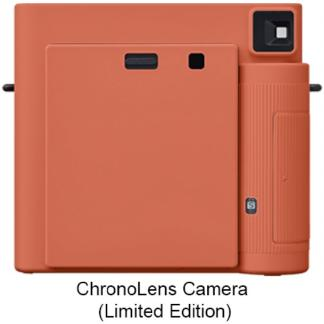

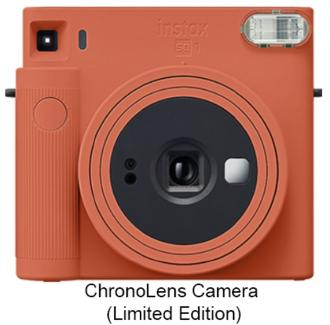

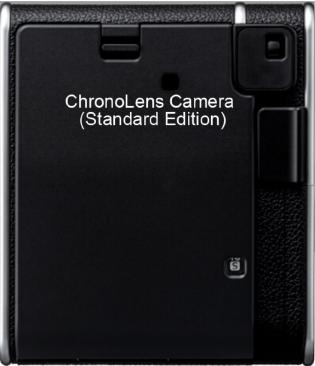

In [17]:
response = chain_with_sources.invoke("what is the picture of ChronoLens Camera (Limited Edi􀆟on)")


print("Response:", response['response'])

print("\n\nContext:")
# for text in response['context']['texts']:
#     print(text.text)
#     print("Page number: ", text.metadata.page_number)
#     print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

In [39]:
vectorstore.similarity_search("what is the shop name?")

[Document(metadata={'doc_id': '66b66048-7f9b-4828-9a1e-79e8d26f59ba'}, page_content='The Wonderful Oddities Shop is a mysterious store selling enchanted artifacts with secrets and curses, where customers browse at their own risk.'),
 Document(metadata={'doc_id': 'ada6d4dc-23d4-48fb-9e44-ea40725d143c'}, page_content='The Wonderful Oddities Shop is a mysterious store selling enchanted artifacts with secrets and curses, where customers browse at their own risk.'),
 Document(metadata={'doc_id': '499fbd04-5c39-425f-a3db-f8adf3151cfc'}, page_content='The Wonderful Oddities Shop, also known as "The Oddities Collection", is a unique store featuring unusual and bizarre items, including taxidermied animals, medical oddities, and other rare and unusual artifacts.'),
 Document(metadata={'doc_id': '1e84921e-84c2-40f0-b39c-f42585d49aac'}, page_content='The Wonderful Oddities Shop, also known as "The Oddities Collection", is a unique store featuring unusual and bizarre items, including taxidermied an